In [51]:
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random
from sklearn.utils import shuffle
from tqdm import tqdm_notebook

data = pd.read_csv('dataset/train_labels.csv')
train_path = 'dataset/train/'
test_path = 'dataset/test/'
# quick look at the label stats
data['label'].value_counts()
print(type(data['label'][0]))

<class 'numpy.int64'>


dataset/train/0576e06d027bbfe88f483904b2624dc07a9c41ca.tif
dataset/train/e04ac54363df1cb9d47338af5ffa6e33b8ae1094.tif
dataset/train/79eb6e38f842f81ac56f0624b1acf4ed78e9067a.tif
dataset/train/cd3081e07906867da5dcda4a58939dce2e828b89.tif
dataset/train/8afcaa31abbe2d499fdba83ac625785bcda52888.tif
dataset/train/138b6b00a9a5ed72392848f1c8ed16ebc526568c.tif
dataset/train/a089c8d3ab5c37ac7a8d51038b95d424f92b2b9b.tif
dataset/train/2ed478cdfc7b8d07ed7b482849763d2bfce3721d.tif
dataset/train/9f0857483fc70630430cb4411b51f591e2d023bd.tif
dataset/train/e58a3bae647112076fa4c6ffe3eebcdcc514d469.tif


Text(0, 0.5, 'Tumor tissue samples')

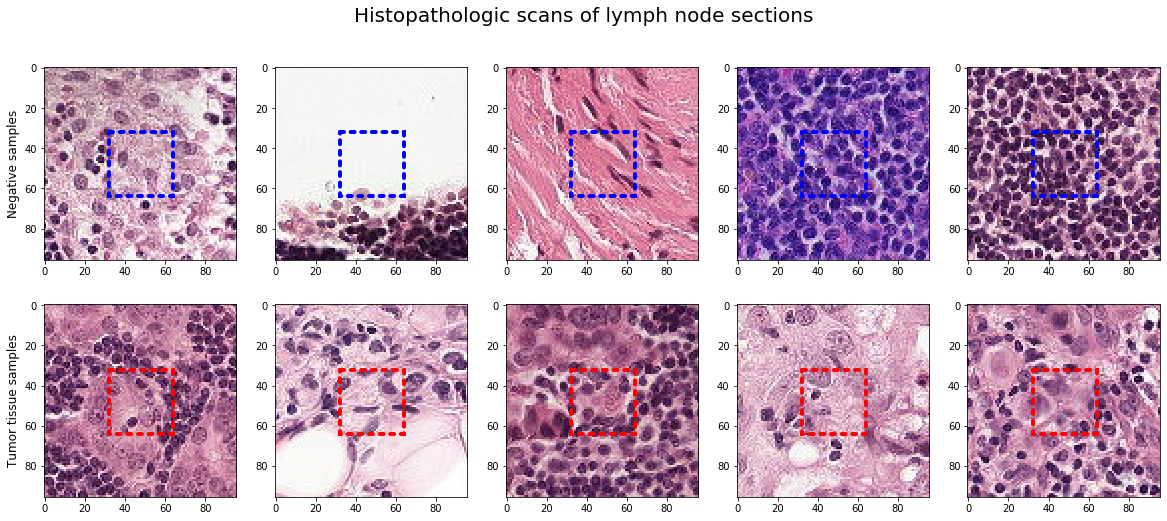

In [52]:
def readImage(path):
    # OpenCV reads the image in bgr format by default
    print(path)
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    return rgb_img

# random sampling
shuffled_data = shuffle(data)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[0,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
    ax[0,i].add_patch(box)
ax[0,0].set_ylabel('Negative samples', size='large')
# Positives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 1]['id'][:5]):
    path = os.path.join(train_path, idx)
    ax[1,i].imshow(readImage(path + '.tif'))
    # Create a Rectangle patch
    box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
    ax[1,i].add_patch(box)
ax[1,0].set_ylabel('Tumor tissue samples', size='large')


In [53]:
##### Essai pour explorer les données
print(i,idx)
print(readImage(path + '.tif').shape)
print(readImage(path + '.tif')[0,2,:])
myCmd = 'du '+ path + '.tif'


4 e58a3bae647112076fa4c6ffe3eebcdcc514d469
dataset/train/e58a3bae647112076fa4c6ffe3eebcdcc514d469.tif
(96, 96, 3)
dataset/train/e58a3bae647112076fa4c6ffe3eebcdcc514d469.tif
[159 113 150]


In [54]:
import random
ORIGINAL_SIZE = 96      # original size of the images - do not change

# AUGMENTATION VARIABLES
CROP_SIZE = 32          # final size after crop
RANDOM_ROTATION = 0#3    # range (0-180), 180 allows all rotation variations, 0=no change
RANDOM_SHIFT = 0#2        # center crop shift in x and y axes, 0=no change. This cannot be more than (ORIGINAL_SIZE - CROP_SIZE)//2 
RANDOM_BRIGHTNESS = 0#7  # range (0-100), 0=no change
RANDOM_CONTRAST = 0#5    # range (0-100), 0=no change
RANDOM_90_DEG_TURN = 0#1  # 0 or 1= random turn to left or right

def readCroppedImage2(path, augmentations = False):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
        return rgb_img / 255
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    return rgb_img


def readCroppedImage(path, augmentations = False):
    # augmentations parameter is included for counting statistics from images, where we don't want augmentations
    
    # OpenCV reads the image in bgr format by default
    bgr_img = cv2.imread(path)
    # We flip it to rgb for visualization purposes
    b,g,r = cv2.split(bgr_img)
    rgb_img = cv2.merge([r,g,b])
    
    if(not augmentations):
         # crop to center and normalize to 0-1 range
        start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
        end_crop = start_crop + CROP_SIZE
        rgb_img = rgb_img[(start_crop ):(end_crop ), (start_crop ):(end_crop )] / 255
        return rgb_img 
    
    #random rotation
    rotation = random.randint(-RANDOM_ROTATION,RANDOM_ROTATION)
    if(RANDOM_90_DEG_TURN == 1):
        rotation += random.randint(-1,1) * 90
    M = cv2.getRotationMatrix2D((48,48),rotation,1)   # the center point is the rotation anchor
    rgb_img = cv2.warpAffine(rgb_img,M,(96,96))
    
    #random x,y-shift
    x = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    y = random.randint(-RANDOM_SHIFT, RANDOM_SHIFT)
    
    # crop to center and normalize to 0-1 range
    start_crop = (ORIGINAL_SIZE - CROP_SIZE) // 2
    end_crop = start_crop + CROP_SIZE
    rgb_img = rgb_img[(start_crop + x):(end_crop + x), (start_crop + y):(end_crop + y)] / 255
    
    # Random flip
    flip_hor = bool(random.getrandbits(1))
    flip_ver = bool(random.getrandbits(1))
    if(flip_hor):
        rgb_img = rgb_img[:, ::-1]
    if(flip_ver):
        rgb_img = rgb_img[::-1, :]
        
    # Random brightness
    br = random.randint(-RANDOM_BRIGHTNESS, RANDOM_BRIGHTNESS) / 100.
    rgb_img = rgb_img + br
    
    # Random contrast
    cr = 1.0 + random.randint(-RANDOM_CONTRAST, RANDOM_CONTRAST) / 100.
    rgb_img = rgb_img * cr
    
    # clip values to 0-1 range
    rgb_img = np.clip(rgb_img, 0, 1.0)
    return rgb_img

(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
(32, 32, 3)
[[[0.27843137 0.18431373 0.30980392]
  [0.34509804 0.24705882 0.36078431]
  [0.60784314 0.50980392 0.59607843]
  ...
  [0.96470588 0.80784314 0.90196078]
  [0.6745098  0.5372549  0.61568627]
  [0.32941176 0.20784314 0.27843137]]

 [[0.28235294 0.16862745 0.29019608]
  [0.39215686 0.2745098  0.38431373]
  [0.49411765 0.38039216 0.46666667]
  ...
  [0.81568627 0.65098039 0.7372549 ]
  [0.95294118 0.81960784 0.88627451]
  [0.81176471 0.69019608 0.75294118]]

 [[0.45882353 0.30196078 0.43529412]
  [0.50196078 0.34901961 0.4627451 ]
  [0.62352941 0.4745098  0.56470588]
  ...
  [0.63529412 0.48235294 0.55294118]
  [0.74509804 0.61176471 0.6745098 ]
  [0.81568627 0.69019608 0.74901961]]

 ...

 [[0.58823529 0.40392157 0.56862745]
  [0.59607843 0.43137255 0.57254902]
  [0.50980392 0.36862745 0.47843137]
  ...
  [0.81960784 0.68627451 0.75294118]
  [0.90980392 0.74117647 0.81960784]
  [0.84313725 0.65490196 0.74117647]]

 [

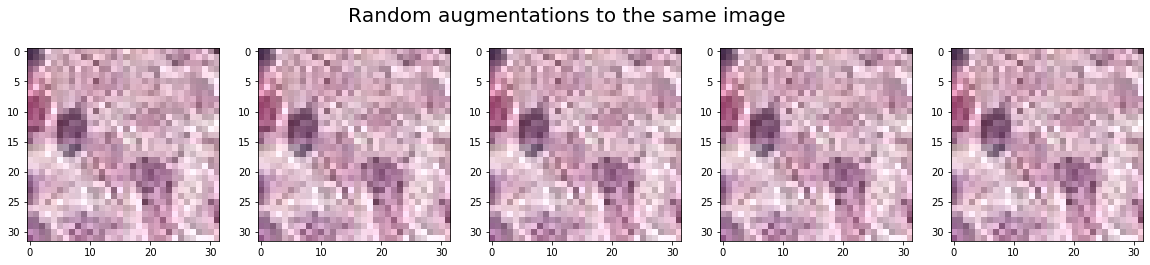

In [55]:
fig, ax = plt.subplots(1,5, figsize=(20,4))
fig.suptitle('Random augmentations to the same image',fontsize=20)
# Negatives
for i, idx in enumerate(shuffled_data[shuffled_data['label'] == 0]['id'][:1]):
    for j in range(5):
        path = os.path.join(train_path, idx)
        ax[j].imshow(readCroppedImage(path + '.tif'))
        if j == 4 :
            print(readCroppedImage(path + '.tif'))